# Build Graph by BERT


- node: the embeddings of the content (BERT)
- edge: the similarity between the nodes (KNN)

In [1]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Load the dataset

In [2]:
from datasets import load_dataset

/home/littlefish/miniconda3/envs/fake/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load and download the dataset from huggingface
dataset = load_dataset("LittleFish-Coder/Fake-News-Detection-Challenge-KDD-2020", download_mode="reuse_cache_if_exists", cache_dir="dataset")

Generating test split: 100%|██████████| 499/499 [00:00<00:00, 21558.21 examples/s]


In [4]:
print(f"Dataset Type: {type(dataset)}")
print(f"{dataset}")
print(f"Dataset keys: {dataset.keys()}")

Dataset Type: <class 'datasets.dataset_dict.DatasetDict'>
DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 3490
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 997
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 499
    })
})
Dataset keys: dict_keys(['train', 'validation', 'test'])


In [5]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]
print(f"Train dataset type: {type(train_dataset)}")
print(f"Validation dataset type: {type(val_dataset)}")
print(f"Test dataset type: {type(test_dataset)}")

Train dataset type: <class 'datasets.arrow_dataset.Dataset'>
Validation dataset type: <class 'datasets.arrow_dataset.Dataset'>
Test dataset type: <class 'datasets.arrow_dataset.Dataset'>


In [6]:
# First element of the train dataset
print(f"{train_dataset[0].keys()}")
print(f"Text: {train_dataset[0]['text']}")
print(f"Label: {train_dataset[0]['label']}")

dict_keys(['text', 'label', '__index_level_0__'])
Text: UPDATE, WRITETHRU with more detail: Shortly before he was due to appear on ITV’s Good Morning Britain today, Ewan McGregor pulled out of the interview, citing comments made about this weekend’s Women’s March by host Piers Morgan. A supporter of President Donald Trump, Morgan yesterday on the program described some of the women who marched as “rabid feminists” and said he didn’t “see the point of the march(es)” which he called “generic” and “vacuous.”  On Twitter this morning, McGregor, who is out promoting Trainspotting sequel T2: Trainspotting, wrote, “Was going on Good Morning Britain, didn’t realise Piers Morgan was host. Won’t go on with him after his comments about #WomensMarch.”  Was going on Good Morning Britain, didn’t realise @piersmorgan was host. Won’t go on with him after his comments about #WomensMarch — Ewan McGregor (@mcgregor_ewan) January 24, 2017  On his Twitter account (whose timeline photo is of he and Trump), 

# Load Tokenizer and Model

In [7]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained(f"google-bert/bert-base-uncased", clean_up_tokenization_spaces=True)
model = AutoModel.from_pretrained(f"google-bert/bert-base-uncased").to(device)

In [8]:
inputs = tokenizer(train_dataset[0]['text'], return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
print(f"Input keys: {inputs.keys()}")
print(f"Input ids: {inputs['input_ids']}")
print(f"Attention mask: {inputs['attention_mask']}")

Input keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Input ids: tensor([[  101, 10651,  1010,  4339,  2705,  6820,  2007,  2062,  6987,  1024,
          3859,  2077,  2002,  2001,  2349,  2000,  3711,  2006, 11858,  1521,
          1055,  2204,  2851,  3725,  2651,  1010,  1041,  7447, 23023,  2766,
          2041,  1997,  1996,  4357,  1010,  8951,  7928,  2081,  2055,  2023,
          5353,  1521,  1055,  2308,  1521,  1055,  2233,  2011,  3677, 16067,
          5253,  1012,  1037, 10129,  1997,  2343,  6221,  8398,  1010,  5253,
          7483,  2006,  1996,  2565,  2649,  2070,  1997,  1996,  2308,  2040,
          9847,  2004,  1523, 10958, 17062, 10469,  2015,  1524,  1998,  2056,
          2002,  2134,  1521,  1056,  1523,  2156,  1996,  2391,  1997,  1996,
          2233,  1006,  9686,  1007,  1524,  2029,  2002,  2170,  1523, 12391,
          1524,  1998,  1523, 12436, 10841,  3560,  1012,  1524,  2006, 10474,
          2023,  2851,  1010, 23023,  1010,  20

## Get the embeddings of the content

In [9]:
model.config.output_hidden_states = True

# Get model output with hidden states
with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model(**inputs)

# Now, outputs will have the hidden states
hidden_states = outputs.hidden_states

# The last layer's hidden state can be accessed like this
last_hidden_state = outputs.last_hidden_state

# take the mean of the last hidden state
embeddings = last_hidden_state.mean(dim=1)

In [10]:
# Let's check the shape of the last hidden state
print(f"There are {len(hidden_states)} hidden states")
print(f"Shape of the last hidden state: {last_hidden_state.shape}")

There are 13 hidden states
Shape of the last hidden state: torch.Size([1, 512, 768])


In [11]:
print(f"Embeddings shape: {embeddings.shape}")
print(f"Embeddings: \n{embeddings}")

Embeddings shape: torch.Size([1, 768])
Embeddings: 
tensor([[-2.5972e-02, -1.0488e-01,  3.3386e-01, -1.6336e-01,  8.4529e-02,
         -4.0408e-02,  1.7998e-01,  3.9875e-01,  1.0262e-01,  1.0095e-01,
         -1.0618e-02, -3.5125e-01, -2.3232e-01,  2.3050e-01, -8.4879e-02,
          4.8300e-01,  6.0474e-02,  6.9526e-02, -2.3808e-01,  2.1106e-01,
          4.4448e-01,  3.0798e-02,  1.2963e-01,  3.8113e-01,  5.4776e-01,
          1.5527e-02,  6.9571e-02, -2.3551e-01, -3.5181e-01, -3.1960e-02,
          4.5161e-01,  6.6489e-03, -9.4695e-02, -1.6000e-01, -4.8676e-02,
         -1.4999e-01, -5.0338e-02, -1.4458e-01,  3.4407e-02,  1.4660e-01,
         -6.2394e-01, -2.9785e-01, -2.6332e-02,  1.7596e-01, -2.5245e-01,
         -1.2941e-01,  5.2772e-01,  2.0939e-01,  4.4239e-02, -3.5518e-02,
         -2.0509e-01,  5.1960e-01,  1.9304e-01, -7.7366e-02,  1.2713e-01,
          3.9100e-01, -1.7471e-01, -5.9035e-01, -4.1179e-01, -3.2222e-01,
          1.8764e-01,  1.3571e-01,  4.9532e-02, -3.7943e-01,

# Create Class Model

Now that we know how to get the embeddings of the content, 

we can create a class model that will take the dataset and get the embeddings of the content.

In [12]:
print(type(train_dataset))

<class 'datasets.arrow_dataset.Dataset'>


In [13]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

class CustomDataset(Dataset):
    def __init__(self, texts, labels, model_name='bert-base-uncased', max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=True)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text
        inputs = self.tokenizer(text, padding=True, truncation=True, max_length=self.max_length, return_tensors='pt')
        # Move inputs to CUDA
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

        # Get the BERT embeddings
        with torch.no_grad():
            outputs = self.model(**inputs)
            last_hidden_state = outputs.last_hidden_state
            embeddings = last_hidden_state.mean(dim=1)  # [1, 768]
            # flatten the embeddings
            embeddings = embeddings.flatten()  # [768]
            # print(f"Embeddings shape: {embeddings.shape}")

        # put the embeddings into cpu
        embeddings = embeddings.cpu()

        return embeddings, label


In [14]:
new_dataset = CustomDataset(texts=train_dataset['text'], labels=train_dataset['label'])

In [15]:
# show the first element
print(f"Dataset length: {len(new_dataset)}")
print(f"Dataset first element: {new_dataset[0]}")

Dataset length: 3490
Dataset first element: (tensor([-2.5972e-02, -1.0488e-01,  3.3386e-01, -1.6336e-01,  8.4529e-02,
        -4.0408e-02,  1.7998e-01,  3.9875e-01,  1.0262e-01,  1.0095e-01,
        -1.0618e-02, -3.5125e-01, -2.3232e-01,  2.3050e-01, -8.4879e-02,
         4.8300e-01,  6.0474e-02,  6.9526e-02, -2.3808e-01,  2.1106e-01,
         4.4448e-01,  3.0798e-02,  1.2963e-01,  3.8113e-01,  5.4776e-01,
         1.5527e-02,  6.9571e-02, -2.3551e-01, -3.5181e-01, -3.1960e-02,
         4.5161e-01,  6.6489e-03, -9.4695e-02, -1.6000e-01, -4.8676e-02,
        -1.4999e-01, -5.0338e-02, -1.4458e-01,  3.4407e-02,  1.4660e-01,
        -6.2394e-01, -2.9785e-01, -2.6332e-02,  1.7596e-01, -2.5245e-01,
        -1.2941e-01,  5.2772e-01,  2.0939e-01,  4.4239e-02, -3.5518e-02,
        -2.0509e-01,  5.1960e-01,  1.9304e-01, -7.7366e-02,  1.2713e-01,
         3.9100e-01, -1.7471e-01, -5.9035e-01, -4.1179e-01, -3.2222e-01,
         1.8764e-01,  1.3571e-01,  4.9532e-02, -3.7943e-01,  1.3452e-01,
      

# Build Graph

Use KNN to build the graph
- node: the embeddings
- edge: the similarity between the nodes (k=3)

In [16]:
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from torch.utils.data import DataLoader

distances_matrix = []
indices_matrix = []

def build_knn_graph(dataset, k=5, batch_size=128):
    # Create a DataLoader to efficiently process the dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    all_embeddings = []
    all_labels = []
    
    # Collect all embeddings and labels
    for embeddings, labels in dataloader:
        all_embeddings.append(embeddings.cpu().numpy())
        all_labels.extend(labels.tolist())
    
    # Concatenate all embeddings
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    
    # Fit the NearestNeighbors model
    nn = NearestNeighbors(n_neighbors=k+1, metric='cosine')
    nn.fit(all_embeddings)

    # clear the distances_matrix
    global distances_matrix
    global indices_matrix
    distances_matrix = []
    indices_matrix = []
    # Find k nearest neighbors for each point
    distances, indices = nn.kneighbors(all_embeddings)

    # threshold = np.percentile(distances, 70)

    # store the distances and indices
    distances_matrix.append(distances)
    indices_matrix.append(indices)
    
    # Create a graph
    G = nx.Graph()
    
    # Add nodes with labels
    for i, label in enumerate(all_labels):
        G.add_node(i, label=label)
    
    # Add edges to the graph
    for i in range(len(all_embeddings)):
        for j in range(1, k+1):  # Start from 1 to skip self
            neighbor_idx = indices[i, j]
            distance = distances[i, j]
            if distance < 0.1:
                G.add_edge(i, neighbor_idx, weight=1-distance)  # Convert distance to similarity
            # G.add_edge(i, neighbor_idx, weight=1-distance)  # Convert distance to similarity
    
    return G

# Build the graph 
graph = build_knn_graph(new_dataset, k=3, batch_size=128)

print(f"Distances matrix: {distances_matrix}")
print(f"Indices matrix: {indices_matrix}")

print(f"Graph has {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges")

# Example of accessing node labels
print("Labels of first 5 nodes:")
for i in range(5):
    print(f"Node {i}: Label {graph.nodes[i]['label']}")

Distances matrix: [array([[0.        , 0.05849975, 0.05945569, 0.05960065],
       [0.        , 0.061845  , 0.06728303, 0.06776905],
       [0.        , 0.09875286, 0.10185146, 0.10220969],
       ...,
       [0.        , 0.07318211, 0.07780695, 0.08173597],
       [0.        , 0.03800333, 0.04375291, 0.04597676],
       [0.        , 0.03597343, 0.03757739, 0.03757739]], dtype=float32)]
Indices matrix: [array([[   0, 1143, 1560, 2178],
       [   1, 1555,  552, 2695],
       [   2,   92,  255, 3158],
       ...,
       [3487, 2760, 3301, 1690],
       [3488,  112, 2407,  336],
       [3489, 3035, 1630,  817]])]
Graph has 3490 nodes and 7655 edges
Labels of first 5 nodes:
Node 0: Label 1
Node 1: Label 0
Node 2: Label 1
Node 3: Label 1
Node 4: Label 0


In [17]:
# number of nodes
print(f"Number of nodes: {graph.number_of_nodes()}")
# number of edges
print(f"Number of edges: {graph.number_of_edges()}")
# Get label distribution
label_distribution = nx.get_node_attributes(graph, 'label')
label_counts = {0: 0, 1: 0}
for label in label_distribution.values():
    label_counts[label] += 1

# Calculate ratio
total = sum(label_counts.values())
ratio = label_counts[1] / label_counts[0] if label_counts[0] != 0 else float('inf')

print(f"Label distribution:")
print(f"Label 0: {label_counts[0]}")
print(f"Label 1: {label_counts[1]}")
print(f"Ratio (1:0): {ratio:.2f}")

Number of nodes: 3490
Number of edges: 7655
Label distribution:
Label 0: 2079
Label 1: 1411
Ratio (1:0): 0.68


## Visualize the graph

/tmp/ipykernel_3850803/2002131127.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(unique_labels)))
/tmp/ipykernel_3850803/2002131127.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


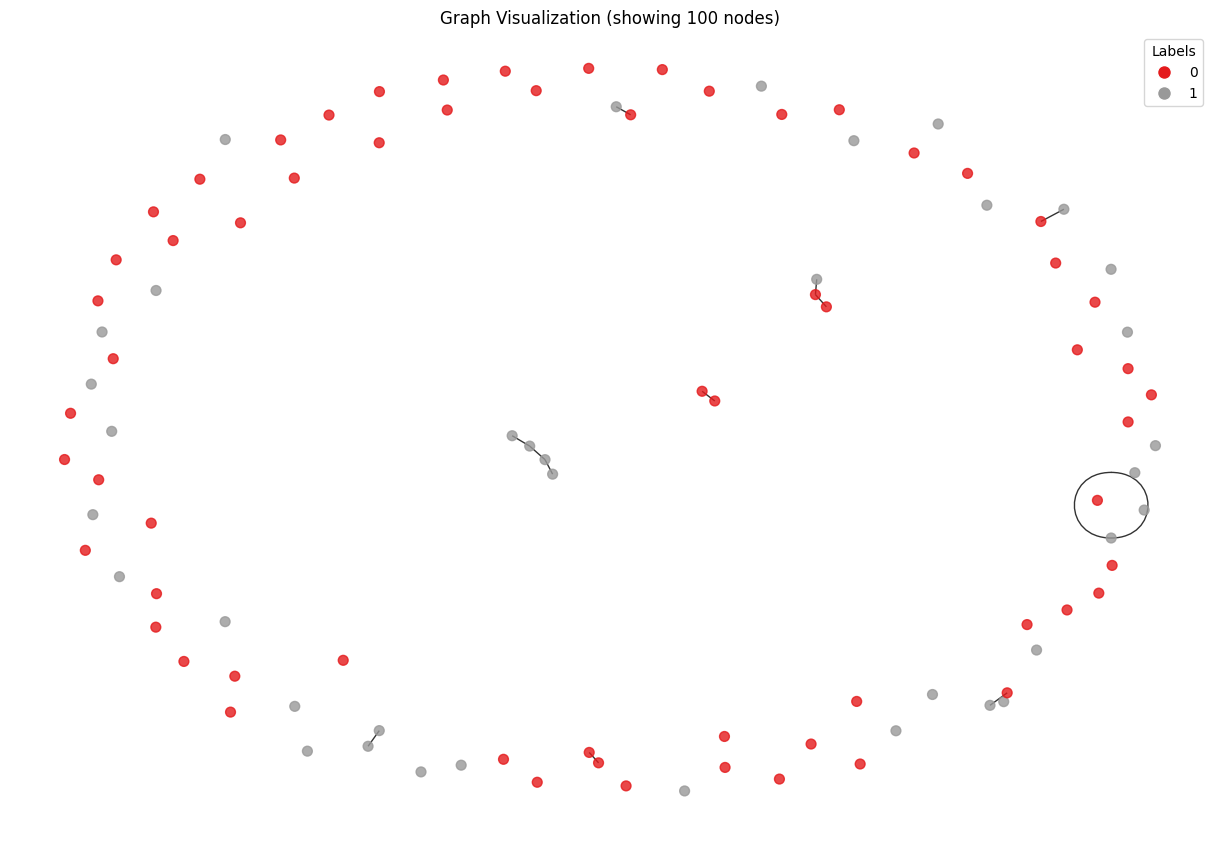

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G, max_nodes=100):
    # If the graph is too large, take a subgraph
    if G.number_of_nodes() > max_nodes:
        nodes = list(G.nodes())[:max_nodes]
        G = G.subgraph(nodes)
    
    # Get node colors based on labels
    labels = nx.get_node_attributes(G, 'label')
    unique_labels = set(labels.values())
    color_map = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(unique_labels)))
    color_dict = dict(zip(unique_labels, color_map))
    node_colors = [color_dict[labels[node]] for node in G.nodes()]
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50, alpha=0.8)
    
    # Add a legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                       markerfacecolor=color_dict[label], markersize=10)
                       for label in unique_labels]
    plt.legend(handles=legend_elements, title="Labels")
    
    plt.title(f"Graph Visualization (showing {G.number_of_nodes()} nodes)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming you've already created your graph
# graph = build_knn_graph(custom_dataset, k=5, batch_size=128)

visualize_graph(graph)